# UAS Data Mining 1 - Kelompok E

## Mata Kuliah Data Mining 1 Kelas SD-A1


# Introduction👋

*   Ilham Dicky Darmawan			(164221023)
*   Erwina Yolavania				(164221037)
*   Raissa Dinda Maya Sabilla		(164221069)
*   Patricia Dewinta Wahyu Krisnayanti	(164221079)
*   Fadli Muhammad 	            		(164221081)

---

**Dataset Scrapping Mamikos**

Link Dataset : https://mamikos.com/kost/kost-dekat-unair-surabaya-murah

Objective :
mengkategorikan kos menggunakan faktor harga, fasilitas kos, tipe kos untuk menemukan opsi paling ekonomis sesuai kebutuhan.

Data Description:

# Library📚

In [ ]:
!pip install kneed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# Read Data📖

In [ ]:
df = pd.read_csv('/content/data_mamikos_scrapping_1-juni.csv')

In [ ]:
df.head()

,name,price,facilities,tipe
0,Kost Singgahsini Opung Erwin Tipe A Mojo Surab...,Rp1.605.000 /bulan,"K. Mandi Dalam ·, K. Mandi Dalam, ·, WiFi ·, W...",Campur
1,Kost Singgahsini Graha Ara Dharmahusada Tipe B...,Rp2.708.750 (Bulan pertama),"K. Mandi Dalam ·, K. Mandi Dalam, ·, WiFi ·, W...",Campur
2,Kost Singgahsini Kertajaya Utimami Tipe A Gube...,Rp1.521.000 (Bulan pertama),"K. Mandi Dalam ·, K. Mandi Dalam, ·, WiFi ·, W...",Putri
3,Kost Singgahsini Graha Ara Dharmahusada Tipe A...,Rp3.359.500 (Bulan pertama),"K. Mandi Dalam ·, K. Mandi Dalam, ·, WiFi ·, W...",Campur
4,Kost Singgahsini Kertajaya Utimami Tipe C Gube...,Rp1.609.000 (Bulan pertama),"K. Mandi Dalam ·, K. Mandi Dalam, ·, WiFi ·, W...",Putri


# Data Cleaning (setelah scrapping)🧹

In [ ]:
# 1. Memisahkan kecamatan dari kolom name
def kecamatan(name):
    words = name.split()
    return ' '.join(words[-2:])

# 2. Membersihkan kolom price
def clean_price(price):
    return int(re.sub(r'[^0-9]', '', price))

# 3. Memisahkan "Kos Andalan" dan tipe gender dari kolom tipe
def kos_andalan(tipe):
    return 'Kos Andalan' if 'Kos Andalan' in str(tipe) else ''

# 4. Memisahkan gender
def gender(tipe):
    if 'Putra' in str(tipe):
        return 'Putra'
    elif 'Putri' in str(tipe):
        return 'Putri'
    elif 'Campur' in str(tipe):
        return 'Campur'
    else:
        return ''

df['kecamatan'] = df['name'].apply(kecamatan)
df['price'] = df['price'].apply(clean_price)
df['kos_andalan'] = df['tipe'].apply(kos_andalan)
df['gender'] = df['tipe'].apply(gender)

In [ ]:
df.head()

,name,price,facilities,tipe,kecamatan,kos_andalan,gender
0,Kost Singgahsini Opung Erwin Tipe A Mojo Surab...,1605000,"K. Mandi Dalam ·, K. Mandi Dalam, ·, WiFi ·, W...",Campur,Kecamatan Gubeng,,Campur
1,Kost Singgahsini Graha Ara Dharmahusada Tipe B...,2708750,"K. Mandi Dalam ·, K. Mandi Dalam, ·, WiFi ·, W...",Campur,Kecamatan Gubeng,,Campur
2,Kost Singgahsini Kertajaya Utimami Tipe A Gube...,1521000,"K. Mandi Dalam ·, K. Mandi Dalam, ·, WiFi ·, W...",Putri,Surabaya Gubeng,,Putri
3,Kost Singgahsini Graha Ara Dharmahusada Tipe A...,3359500,"K. Mandi Dalam ·, K. Mandi Dalam, ·, WiFi ·, W...",Campur,Kecamatan Gubeng,,Campur
4,Kost Singgahsini Kertajaya Utimami Tipe C Gube...,1609000,"K. Mandi Dalam ·, K. Mandi Dalam, ·, WiFi ·, W...",Putri,Surabaya Gubeng,,Putri


Dataset di atas sudah berubah sesuai dengan penerapan fungsi di atas

In [ ]:
facilities_dummies = df['facilities'].str.get_dummies(sep=', ')

df = pd.concat([df, facilities_dummies], axis=1)

In [ ]:
rating = ['1.3','1.4','1.8','2.3','2.5','2.8','3.1','3.4', '3.8', '4.0', '4.1', '4.4', '4.5', '4.6', '4.8', '4.9', '5.0']

def benerin_rating(row):
    for col in rating:
        if row[col] == 1:
            return float(col)
    return None

df['rating'] = df.apply(benerin_rating, axis=1)

In [ ]:
# Menentukan kolom yang tidak digunakan untuk clustering
hapus_kolom = ['tipe', 'facilities', '1.3','1.4','1.8','2.3','2.5','2.8','3.1','3.4', '3.8', '4.0', '4.1', '4.4', '4.5', '4.6', '4.8', '4.9', '5.0']

# Menghapus kolom yang tidak digunakan
df = df.drop(columns=hapus_kolom)

In [ ]:
# menggabungkan kolom yang sama
df['kasur'] = df[['Kasur', 'Kasur ·']].max(axis=1)
df['ac'] = df[['AC', 'AC ·']].max(axis=1)
df['Kamar Mandi Dalam'] = df[['K. Mandi Dalam', 'K. Mandi Dalam ·']].max(axis=1)
df['kloset duduk'] = df[['Kloset Duduk', 'Kloset Duduk ·']].max(axis=1)
df['Wifi'] = df[['WiFi', 'WiFi ·']].max(axis=1)

df.drop(columns=(['Kasur', 'Kasur ·']), inplace=True)
df.drop(columns=(['AC', 'AC ·']), inplace=True)
df.drop(columns=(['K. Mandi Dalam', 'K. Mandi Dalam ·']), inplace=True)
df.drop(columns=(['Kloset Duduk', 'Kloset Duduk ·']), inplace=True)
df.drop(columns=(['WiFi', 'WiFi ·']), inplace=True)
df.drop(columns=(['·']), inplace=True)

In [ ]:
# mengubah nilai kosong menjadi NaN
df.replace('', np.nan, inplace=True)
df.replace(' ', np.nan, inplace=True)
df.replace('-', np.nan, inplace=True)

In [ ]:
df.head()

,name,price,kecamatan,kos_andalan,gender,Akses 24 Jam,rating,kasur,ac,Kamar Mandi Dalam,kloset duduk,Wifi
0,Kost Singgahsini Opung Erwin Tipe A Mojo Surab...,1605000,Kecamatan Gubeng,NaN,Campur,1,4.6,1,1,1,1,1
1,Kost Singgahsini Graha Ara Dharmahusada Tipe B...,2708750,Kecamatan Gubeng,NaN,Campur,1,4.8,1,1,1,1,1
2,Kost Singgahsini Kertajaya Utimami Tipe A Gube...,1521000,Surabaya Gubeng,NaN,Putri,0,4.5,1,1,1,1,1
3,Kost Singgahsini Graha Ara Dharmahusada Tipe A...,3359500,Kecamatan Gubeng,NaN,Campur,1,5.0,1,1,1,1,1
4,Kost Singgahsini Kertajaya Utimami Tipe C Gube...,1609000,Surabaya Gubeng,NaN,Putri,0,NaN,1,1,1,1,1


- Kolom 'Tipe' dan 'Facilities' sudah terhapus

- Terdapat 7 kolom baru, yaitu 'Akses 24 Jam', 'rating', 'kasur', 'ac', 'Kamar Mandi Dalam', 'Kloset Duduk', dan  'Wifi'

In [ ]:
df.to_csv('clean.csv',header=True)

# Informasi Data 🛈

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1868 entries, 0 to 1867
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               1868 non-null   object 
 1   price              1868 non-null   int64  
 2   kecamatan          1868 non-null   object 
 3   kos_andalan        1254 non-null   object 
 4   gender             1868 non-null   object 
 5   Akses 24 Jam       1868 non-null   int64  
 6   rating             416 non-null    float64
 7   kasur              1868 non-null   int64  
 8   ac                 1868 non-null   int64  
 9   Kamar Mandi Dalam  1868 non-null   int64  
 10  kloset duduk       1868 non-null   int64  
 11  Wifi               1868 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 175.2+ KB


Dataframe memiliki 1868 baris dan 12 kolom

Tipe data :
1. float64: 1 kolom ('rating')
2. int64: 7 kolom ('price','Akses 24 Jam', 'kasur', 'ac', 'Kamar Mandi Dalam', 'kloset duduk', 'Wifi')
3. object: 4 kolom ('name', 'kecamatan', 'kos_andalan', 'gender')

Tetapi, terdapat beberapa nilai yang hilang (null) pada kolom 'kos_andalan', 'gender', dan 'rating'

In [ ]:
df.describe()

,price,Akses 24 Jam,rating,kasur,ac,Kamar Mandi Dalam,kloset duduk,Wifi
count,1.868000e+03,1868.000000,416.000000,1868.000000,1868.000000,1868.000000,1868.000000,1868.000000
mean,1.279356e+06,0.755889,4.316587,0.951820,0.563169,0.513919,0.688972,0.752677
std,7.365358e+05,0.429674,1.012733,0.214203,0.496126,0.499940,0.463038,0.431572
min,4.000000e+05,0.000000,1.300000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.500000e+05,1.000000,4.100000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,1.200000e+06,1.000000,4.800000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.600000e+06,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,8.250000e+06,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Data Preprocessing📊

## Cek Duplicate Data

In [ ]:
duplicate = df[df.duplicated()]
print("Duplicate Rows : ",len(duplicate))

Duplicate Rows :  1628


Ditemukan 1628 data duplikat pada dataset

In [ ]:
df = df.drop_duplicates(subset=None, keep="first", inplace=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 1030
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               240 non-null    object 
 1   price              240 non-null    int64  
 2   kecamatan          240 non-null    object 
 3   kos_andalan        165 non-null    object 
 4   gender             240 non-null    object 
 5   Akses 24 Jam       240 non-null    int64  
 6   rating             60 non-null     float64
 7   kasur              240 non-null    int64  
 8   ac                 240 non-null    int64  
 9   Kamar Mandi Dalam  240 non-null    int64  
 10  kloset duduk       240 non-null    int64  
 11  Wifi               240 non-null    int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 24.4+ KB


Setelah melakukan drop pada data duplikat, baris berubah menjadi 240 dan 12 kolom

Tetapi, masih ditemukan beberapa nilai yang hilang (null) pada kolom 'kos_andalan', 'gender', dan 'rating' sehingga perlu dilakukan drop untuk kolom tersebut

## Cek Missing Values


In [ ]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

print(f'Missing Values:\n{missing_values}\nPersentasi:\n{missing_percentage}')

Missing Values:
name                   0
price                  0
kecamatan              0
kos_andalan           75
gender                 0
Akses 24 Jam           0
rating               180
kasur                  0
ac                     0
Kamar Mandi Dalam      0
kloset duduk           0
Wifi                   0
dtype: int64
Persentasi:
name                  0.00
price                 0.00
kecamatan             0.00
kos_andalan          31.25
gender                0.00
Akses 24 Jam          0.00
rating               75.00
kasur                 0.00
ac                    0.00
Kamar Mandi Dalam     0.00
kloset duduk          0.00
Wifi                  0.00
dtype: float64


Terdapat missing values pada atribut rating, gender dan kos_andalan

In [ ]:
df.drop(columns=(['rating', 'kos_andalan']), inplace=True)

Melakukan drop untuk kolom 'rating' dan 'kos_andalan'

## Cek Outlier

In [ ]:
def cek_outlier(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

cek_outlier(df, 'price')

,name,price,kecamatan,gender,Akses 24 Jam,kasur,ac,Kamar Mandi Dalam,kloset duduk,Wifi
3,Kost Singgahsini Graha Ara Dharmahusada Tipe A...,3359500,Kecamatan Gubeng,Campur,1,1,1,1,1,1
13,Kost Sabaya House Tipe Single Gubeng Surabaya ...,3250000,Surabaya Gubeng,Campur,1,1,1,0,1,1
43,Kost Stayvie Coliving Duo Premium Suite Tegals...,8250000,Kecamatan Tegalsari,Campur,1,1,1,1,1,1
55,Kost Stayvie Coliving Tipe Compact Duo Serenit...,7250000,Kecamatan Tegalsari,Campur,1,1,1,1,1,1
73,Kost Residence VIP 222 Tambaksari Surabaya Kec...,3000000,Kecamatan Tambaksari,Campur,1,1,1,1,1,1
75,Kost Casa De Java 1 Gubeng Surabaya Gubeng,3000000,Surabaya Gubeng,Campur,1,1,1,1,1,1
169,Kost Vip Pot Art Gubeng Surabaya Gubeng,3000000,Surabaya Gubeng,Campur,0,1,1,1,1,1


In [ ]:
# IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# hapus outlier price
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

## Explore Data Kecamatan

In [ ]:
df['kecamatan'].unique()

array(['Kecamatan Gubeng', 'Surabaya Gubeng', 'Kecamatan Tambaksari',
       'Kecamatan Tegalsari', 'Surabaya Tambaksari', 'Surabaya Tegalsari',
       'Surabaya Genteng', 'Surabaya Wonokromo', 'Kecamatan Mulyorejo',
       'Kecamatan Genteng', 'Surabaya Sukolilo', 'Surabaya Mulyorejo',
       'Kecamatan Sukolilo'], dtype=object)

karena masih terdapat beberapa data yang tidak konsisten seperti "Kecamatan Mulyorejo" dan "Surabaya Mulyorejo" yang seharusnya satu kesatuan yang sama.

In [ ]:
konsistensi_kecamatan = {
    'Surabaya Gubeng': 'Kecamatan Gubeng',
    'Surabaya Tambaksari': 'Kecamatan Tambaksari',
    'Surabaya Tegalsari': 'Kecamatan Tegalsari',
    'Surabaya Genteng': 'Kecamatan Genteng',
    'Surabaya Wonokromo': 'Kecamatan Wonokromo',
    'Surabaya Mulyorejo': 'Kecamatan Mulyorejo',
    'Surabaya Sukolilo': 'Kecamatan Sukolilo'
}

df['kecamatan'] = df['kecamatan'].replace(konsistensi_kecamatan)

<ipython-input-318-67c0610e238e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kecamatan'] = df['kecamatan'].replace(konsistensi_kecamatan)


In [ ]:
df['kecamatan'].unique()

array(['Kecamatan Gubeng', 'Kecamatan Tambaksari', 'Kecamatan Tegalsari',
       'Kecamatan Genteng', 'Kecamatan Wonokromo', 'Kecamatan Mulyorejo',
       'Kecamatan Sukolilo'], dtype=object)

Beberapa data sudah berubah menjadi satu kesatuan, yaitu dengan berubahnya kata "surabaya" menjadi "Kecamatan". Data yang awalnya "Surabaya Mulyorejo" berubah menjadi "Kecamatan Mulyorejo"

## Explore Data Gender

In [ ]:
df['gender'].unique()

array(['Campur', 'Putri', 'Putra'], dtype=object)

# Scalling Data Numerik

In [ ]:
df_cleaned = df.copy()

In [ ]:
scaler = StandardScaler()

df_cleaned['price'] = scaler.fit_transform(df_cleaned['price'].values.reshape(-1, 1))

In [ ]:
df.head()

,name,price,kecamatan,gender,Akses 24 Jam,kasur,ac,Kamar Mandi Dalam,kloset duduk,Wifi
0,Kost Singgahsini Opung Erwin Tipe A Mojo Surab...,1605000,Kecamatan Gubeng,Campur,1,1,1,1,1,1
1,Kost Singgahsini Graha Ara Dharmahusada Tipe B...,2708750,Kecamatan Gubeng,Campur,1,1,1,1,1,1
2,Kost Singgahsini Kertajaya Utimami Tipe A Gube...,1521000,Kecamatan Gubeng,Putri,0,1,1,1,1,1
4,Kost Singgahsini Kertajaya Utimami Tipe C Gube...,1609000,Kecamatan Gubeng,Putri,0,1,1,1,1,1
5,Kost Singgahsini Kertajaya Utimami Tipe B Gube...,1564000,Kecamatan Gubeng,Putri,0,1,1,1,1,1


Kolom 'price' sudah menjadi normal dan memiliki skala seragam dengan bantuan `StandarScaler`

# Dummy Variabel Variabel Kategorik

In [ ]:
df_cleaned = pd.get_dummies(df_cleaned, columns=['kecamatan', 'gender'])

# Ganti nilai True/False menjadi 1/0 hanya untuk kolom 'kecamatan' dan 'gender'
kecamatan_columns = [col for col in df_cleaned.columns if col.startswith('kecamatan_')]
gender_columns = [col for col in df_cleaned.columns if col.startswith('gender_')]

# Ubah nilai True/False menjadi 1/0 menggunakan looping
for col in kecamatan_columns + gender_columns:
    df_cleaned[col] = df_cleaned[col].astype(int)

In [ ]:
df_cleaned.head()

,name,price,Akses 24 Jam,kasur,ac,Kamar Mandi Dalam,kloset duduk,Wifi,kecamatan_Kecamatan Genteng,kecamatan_Kecamatan Gubeng,kecamatan_Kecamatan Mulyorejo,kecamatan_Kecamatan Sukolilo,kecamatan_Kecamatan Tambaksari,kecamatan_Kecamatan Tegalsari,kecamatan_Kecamatan Wonokromo,gender_Campur,gender_Putra,gender_Putri
0,Kost Singgahsini Opung Erwin Tipe A Mojo Surab...,0.722310,1,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0
1,Kost Singgahsini Graha Ara Dharmahusada Tipe B...,2.771395,1,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0
2,Kost Singgahsini Kertajaya Utimami Tipe A Gube...,0.566366,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,1
4,Kost Singgahsini Kertajaya Utimami Tipe C Gube...,0.729736,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,1
5,Kost Singgahsini Kertajaya Utimami Tipe B Gube...,0.646194,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,1


# PCA

In [ ]:
# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_pca)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

                                     PC1       PC2
price                           0.983708 -0.006734
Akses 24 Jam                    0.009270 -0.023026
kasur                           0.029952 -0.034162
ac                              0.401661 -0.070061
Kamar Mandi Dalam               0.351752 -0.051832
kloset duduk                    0.230061 -0.142559
Wifi                            0.099386 -0.165635
kecamatan_Kecamatan Genteng     0.019535  0.048677
kecamatan_Kecamatan Gubeng     -0.086594 -0.224206
kecamatan_Kecamatan Mulyorejo   0.012295  0.005095
kecamatan_Kecamatan Sukolilo    0.003224 -0.012622
kecamatan_Kecamatan Tambaksari  0.050403  0.124583
kecamatan_Kecamatan Tegalsari   0.004013  0.059905
kecamatan_Kecamatan Wonokromo  -0.002875 -0.001433
gender_Campur                   0.191084  0.336508
gender_Putra                   -0.132617  0.099721
gender_Putri                   -0.058467 -0.436229


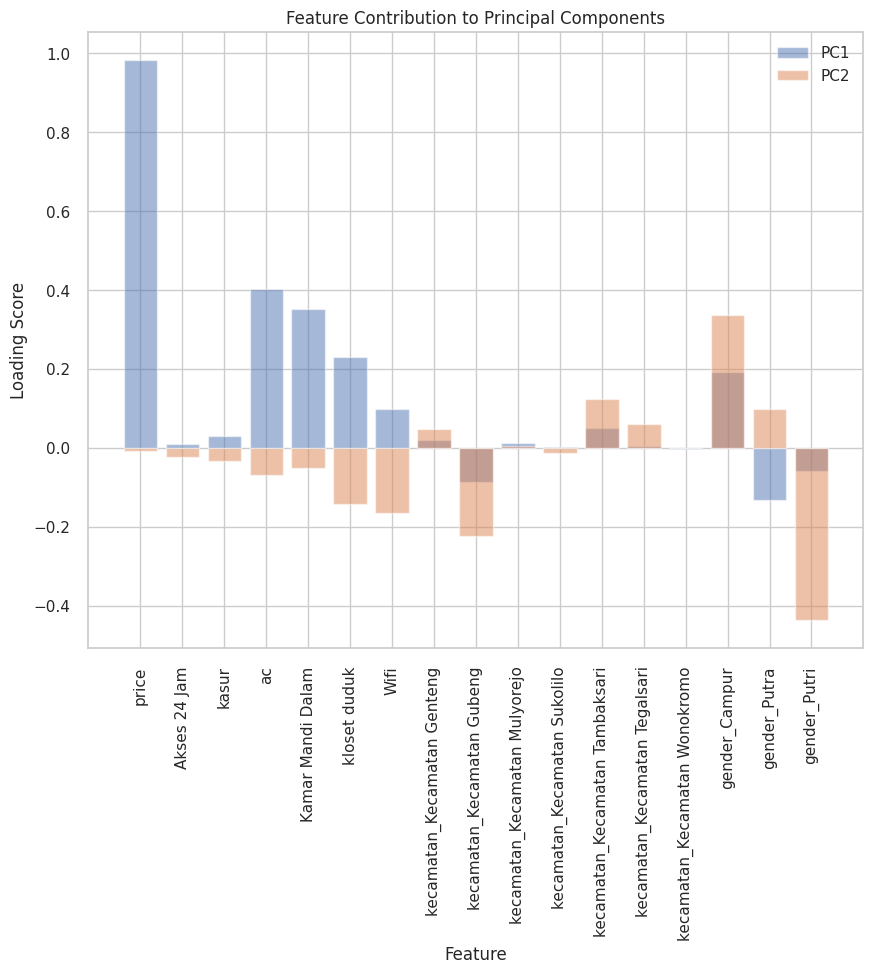

In [ ]:
# Feature loadings
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_.T

loadings = eigenvectors * np.sqrt(eigenvalues)

hasil_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=df_pca.columns)
print(hasil_loadings)

# Visualisasi kontribusi variabel untuk setiap komponen utama
plt.figure(figsize=(10, 8))
plt.bar(hasil_loadings.index, hasil_loadings['PC1'], alpha=0.5, align='center', label='PC1')
plt.bar(hasil_loadings.index, hasil_loadings['PC2'], alpha=0.5, align='center', label='PC2')
plt.xticks(rotation=90)
plt.ylabel('Loading Score')
plt.xlabel('Feature')
plt.title('Feature Contribution to Principal Components')
plt.legend()
plt.show()

Komponen Utama 1 (PC1)
- price (0.983708): Fitur ini memiliki loading positif yang sangat tinggi, menunjukkan bahwa harga sangat berkontribusi pada PC1. Nilai PC1 yang tinggi sangat terkait dengan harga yang lebih tinggi.
- ac (0.401661): Fitur ini juga memiliki loading positif, meskipun lebih rendah daripada price. Ini menunjukkan bahwa keberadaan AC berkontribusi positif pada PC1.
- Kamar Mandi Dalam (0.351752): Keberadaan kamar mandi dalam juga berkontribusi positif pada PC1.
- kloset duduk (0.230061): Keberadaan kloset duduk berkontribusi positif, tetapi dengan tingkat yang lebih rendah.
- gender_Campur (0.191084): Properti dengan gender campur berkontribusi positif pada PC1.
- Fitur-fitur lainnya memiliki kontribusi yang relatif lebih kecil pada PC1.

Komponen Utama 2 (PC2)
- gender_Putri (-0.436229): Fitur ini memiliki loading negatif yang tinggi, menunjukkan bahwa properti yang khusus untuk perempuan berkontribusi negatif pada PC2.
- gender_Campur (0.336508): Properti dengan gender campur berkontribusi positif pada PC2.
- kecamatan_Kecamatan Gubeng (-0.224206): Kecamatan ini berkontribusi negatif pada PC2.
- Wifi (-0.165635): Ketersediaan Wi-Fi berkontribusi negatif pada PC2.
- gender_Putra (0.099721): Properti yang khusus untuk laki-laki berkontribusi positif pada PC2.
- Fitur-fitur lainnya memiliki kontribusi yang lebih kecil pada PC2.

Interpretasi Umum
- PC1 terutama terkait dengan harga properti, diikuti oleh fasilitas seperti AC, kamar mandi dalam, dan kloset duduk. Ini menunjukkan bahwa properti dengan harga yang lebih tinggi cenderung memiliki fasilitas-fasilitas tersebut.
- PC2 dipengaruhi oleh eksklusivitas gender properti, dengan properti khusus untuk perempuan berkontribusi negatif dan properti gender campur berkontribusi positif. Kecamatan Gubeng dan ketersediaan Wi-Fi juga memiliki kontribusi yang signifikan namun negatif.

# K-Means Clustering💻

In [ ]:
df_kmeans = pca_df.copy()

## Elbow Method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

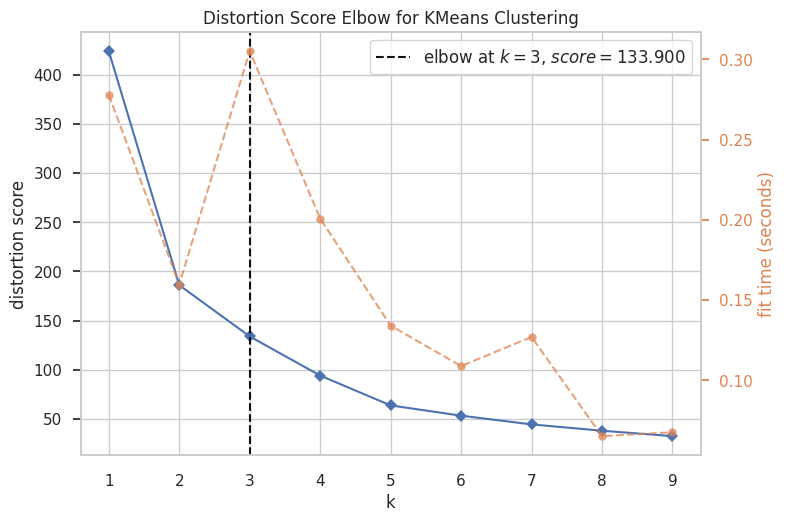

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Plotting Elbow Curve
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(df_kmeans)
visualizer.poof()

Pada grafik, menunjukkan ada penurunan di angka 3, maka nilai elbow atau jumlah cluster optimal nya adalah 3

## Modelling

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(df_kmeans)
print(f'Hasil Clustering:\n{cluster_labels}')

Hasil Clustering:
[0 0 1 1 1 2 1 2 1 2 2 0 0 2 0 2 1 0 1 2 2 0 1 0 0 0 1 0 2 2 1 2 0 2 0 1 0
 0 2 0 2 0 2 1 0 0 2 1 1 1 2 2 1 1 1 1 1 0 1 1 1 2 2 1 0 1 0 1 1 2 2 0 1 2
 2 2 2 1 2 2 0 2 2 2 1 2 2 0 2 0 2 0 0 2 2 2 2 1 2 1 2 2 2 1 2 2 2 2 1 2 0
 2 1 2 2 2 0 2 2 1 2 0 2 0 2 1 1 1 1 1 0 1 2 2 1 0 2 0 2 2 1 1 2 1 1 2 2 0
 2 2 1 2 1 2 2 2 2 1 2 0 0 2 1 1 2 0 1 1 1 2 2 0 2 0 1 0 0 1 0 2 2 0 1 2 1
 2 2 2 2 1 2 0 2 2 2 2 2 2 2 2 2 1 2 0 2 2 0 2 2 2 0 2 0 2 2 2 2 2 2 1 2 2
 2 1 2 2 1 2 1 1 0 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
pd.Series(kmeans.labels_).value_counts()

2    114
1     66
0     53
Name: count, dtype: int64

In [ ]:
kmeans_silhouette = silhouette_score(df_kmeans, cluster_labels)
print(f"K-means Silhouette Score: {kmeans_silhouette}")

K-means Silhouette Score: 0.5297213082395246


In [ ]:
df_kmeans['cluster'] = cluster_labels
df_kmeans.head()

,PC1,PC2,cluster
0,1.108821,0.235255,0
1,2.821813,0.214510,0
2,0.758503,-0.890190,1
3,0.895076,-0.891844,1
4,0.825238,-0.890998,1


## Visualialasi Hasil Clustering

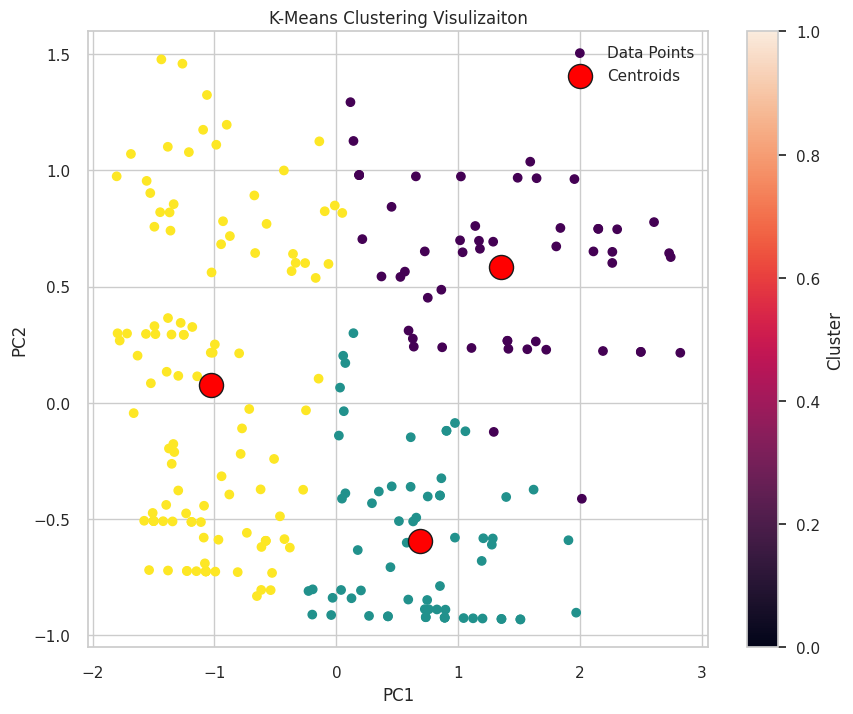

In [ ]:
# Menghitung centroid
centroids = kmeans.cluster_centers_

# Plot hasil klasterisasi PCA
plt.figure(figsize=(10, 8))
plt.scatter(df_kmeans['PC1'], df_kmeans['PC2'], c=df_kmeans['cluster'], cmap='viridis', label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=300, c='red', edgecolors='k', label='Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering Visulizaiton')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

# Identifikasi Pola Hasil Clustering 📈


## Statistika Deskriptif Cluster

In [ ]:
df_hasil = df.copy()

In [ ]:
df_hasil['cluster'] = cluster_labels
df_hasil['PC1'] = df_kmeans['PC1']
df_hasil['PC2'] = df_kmeans['PC2']
df_hasil.head()

,name,price,kecamatan,gender,Akses 24 Jam,kasur,ac,Kamar Mandi Dalam,kloset duduk,Wifi,cluster,PC1,PC2
0,Kost Singgahsini Opung Erwin Tipe A Mojo Surab...,1605000,Kecamatan Gubeng,Campur,1,1,1,1,1,1,0,1.108821,0.235255
1,Kost Singgahsini Graha Ara Dharmahusada Tipe B...,2708750,Kecamatan Gubeng,Campur,1,1,1,1,1,1,0,2.821813,0.214510
2,Kost Singgahsini Kertajaya Utimami Tipe A Gube...,1521000,Kecamatan Gubeng,Putri,0,1,1,1,1,1,1,0.758503,-0.890190
4,Kost Singgahsini Kertajaya Utimami Tipe C Gube...,1609000,Kecamatan Gubeng,Putri,0,1,1,1,1,1,1,0.825238,-0.890998
5,Kost Singgahsini Kertajaya Utimami Tipe B Gube...,1564000,Kecamatan Gubeng,Putri,0,1,1,1,1,1,1,-0.809107,-0.730240


In [ ]:
statistika_deskriptif = df_hasil.groupby('cluster').agg(
    jumlah_data=('name', 'count'),
    harga_rata_rata=('price', 'mean'),
    harga_std=('price', 'std'),
    harga_min=('price', 'min'),
    harga_25_percentile=('price', lambda x: x.quantile(0.25)),
    harga_median=('price', 'median'),
    harga_75_percentile=('price', lambda x: x.quantile(0.75)),
    harga_max=('price', 'max'),
    PC1_mean=('PC1','mean'),
    PC2_mean=('PC2','mean'),
    akses_24_jam_1=('Akses 24 Jam', lambda x: (x == 1).sum()),
    akses_24_jam_0=('Akses 24 Jam', lambda x: (x == 0).sum()),
    kasur_1=('kasur', lambda x: (x == 1).sum()),
    kasur_0=('kasur', lambda x: (x == 0).sum()),
    ac_1=('ac', lambda x: (x == 1).sum()),
    ac_0=('ac', lambda x: (x == 0).sum()),
    kamar_mandi_dalam_1=('Kamar Mandi Dalam', lambda x: (x == 1).sum()),
    kamar_mandi_dalam_0=('Kamar Mandi Dalam', lambda x: (x == 0).sum()),
    kloset_duduk_1=('kloset duduk', lambda x: (x == 1).sum()),
    kloset_duduk_0=('kloset duduk', lambda x: (x == 0).sum()),
    wifi_1=('Wifi', lambda x: (x == 1).sum()),
    wifi_0=('Wifi', lambda x: (x == 0).sum())
)

statistika_deskriptif

,jumlah_data,harga_rata_rata,harga_std,harga_min,harga_25_percentile,harga_median,harga_75_percentile,harga_max,PC1_mean,PC2_mean,...,kasur_1,kasur_0,ac_1,ac_0,kamar_mandi_dalam_1,kamar_mandi_dalam_0,kloset_duduk_1,kloset_duduk_0,wifi_1,wifi_0
cluster,,,,,,,,,,,,,,,,,,,,,
0,53,1.809693e+06,434318.023772,1200000,1500000.0,1800000.0,2200000.0,2708750,0.299086,0.077166,...,51,2,51,2,44,9,45,8,40,13
1,66,1.517927e+06,295373.377554,900000,1300000.0,1500000.0,1700000.0,2300000,0.108774,-0.048394,...,66,0,61,5,52,14,63,3,61,5
2,114,7.650298e+05,193768.666440,400000,600000.0,750000.0,900000.0,1300000,-0.195558,-0.011683,...,105,9,15,99,24,90,50,64,79,35


1. Cluster 0:

- Jumlah data: 53 kos.
- Harga rata-rata: 1,809,693 rupiah.
- Harga minimum: 1,220,000 rupiah.
- Harga maksimum: 2,780,000 rupiah.
- Fasilitas: Sebagian besar kos dalam cluster ini memiliki akses 24 jam, kasur, AC, kamar mandi dalam, kloset duduk, dan WiFi.

2. Cluster 1:

- Jumlah data: 66 kos.
- Harga rata-rata: 1,517,927 rupiah.
- Harga minimum: 970,000 rupiah.
- Harga maksimum: 2,708,750 rupiah.
- Fasilitas: Sebagian besar kos dalam cluster ini juga memiliki akses 24 jam, kasur, AC, kamar mandi dalam, kloset duduk, dan WiFi.

3. Cluster 2:

- Jumlah data: 114 kos.
- Harga rata-rata: 765,029 rupiah.
- Harga minimum: 325,000 rupiah.
- Harga maksimum: 1,100,000 rupiah.
- Fasilitas: Sebagian besar kos dalam cluster ini memiliki akses 24 jam, kasur, AC, kamar mandi dalam, kloset duduk, dan WiFi, meskipun persentasenya mungkin lebih rendah dibandingkan cluster lainnya.

## Visualisasi Pola Cluster

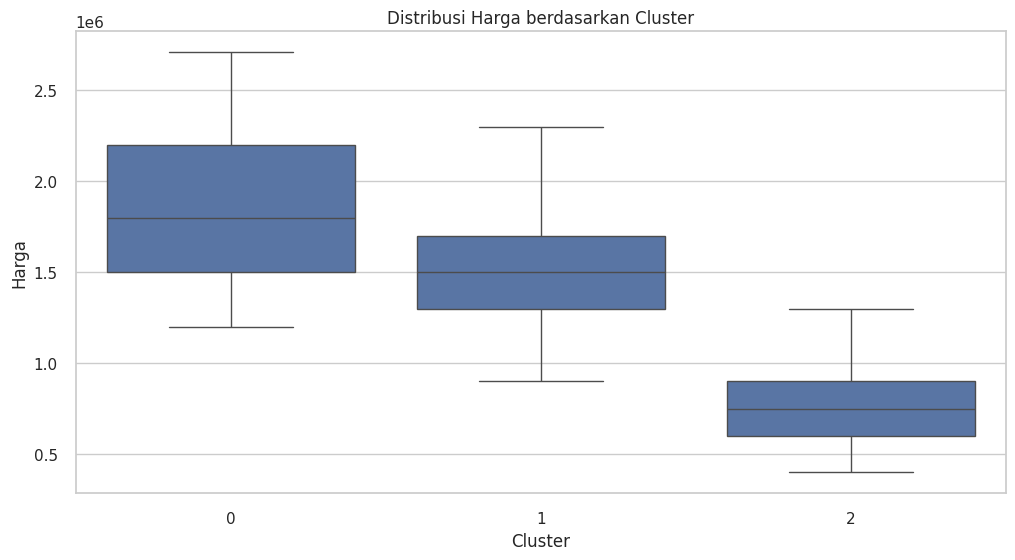

In [ ]:
sns.set(style="whitegrid")

# Plot untuk melihat distribusi harga berdasarkan cluster
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='price', data=df_hasil)
plt.title('Distribusi Harga berdasarkan Cluster')
plt.xlabel('Cluster')
plt.ylabel('Harga')
plt.show()

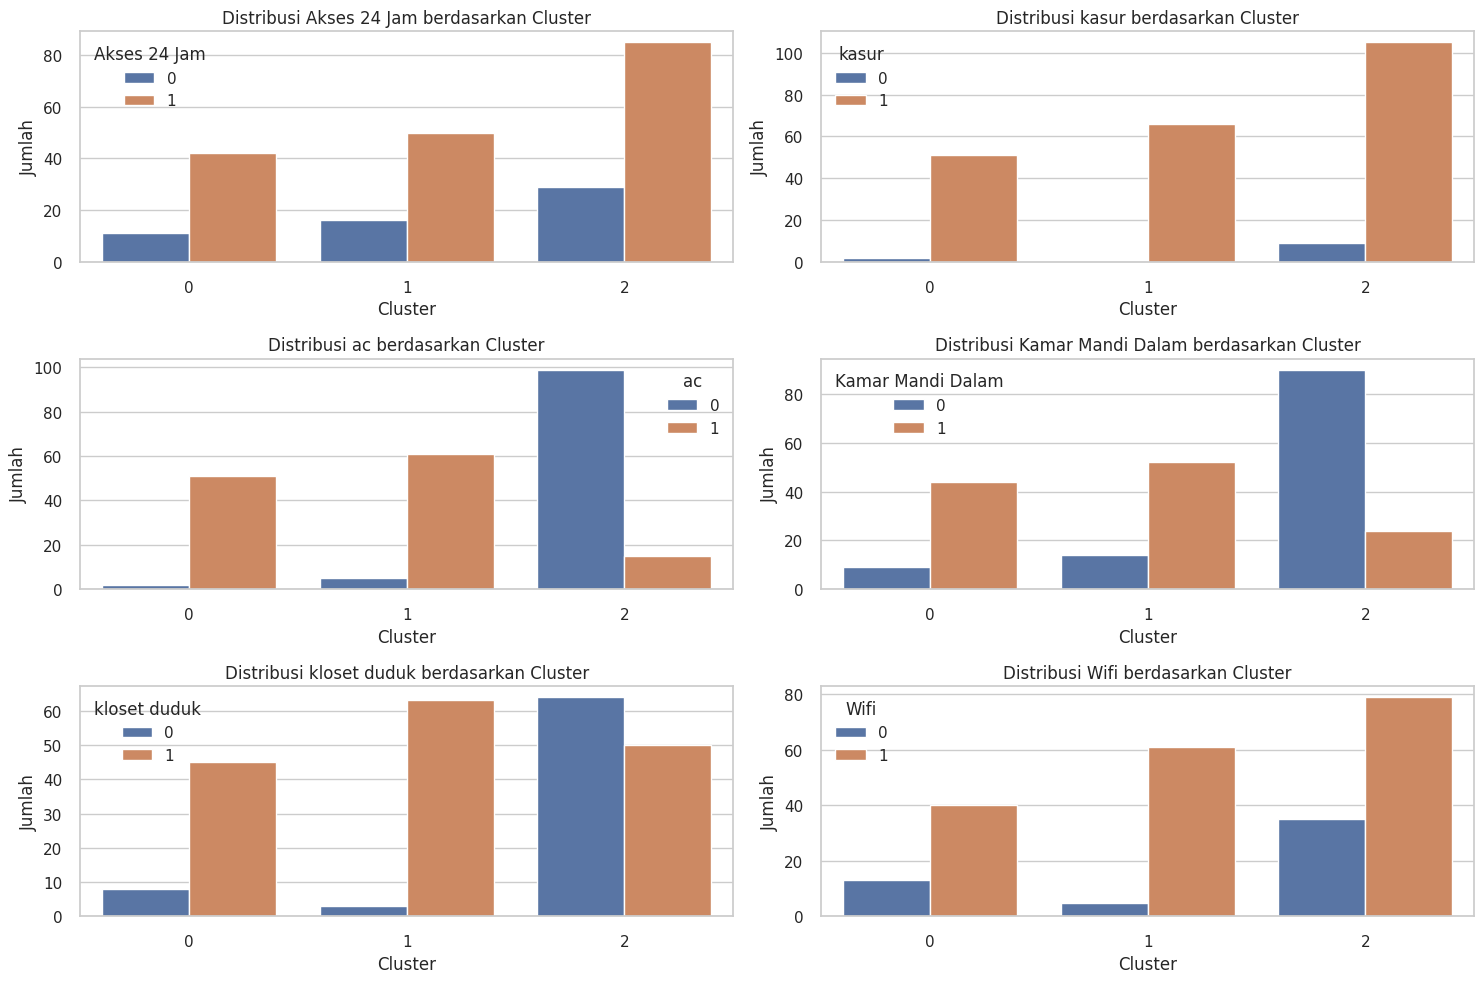

In [ ]:
# Plot untuk melihat distribusi fasilitas berdasarkan cluster
fasilitas = ['Akses 24 Jam', 'kasur', 'ac', 'Kamar Mandi Dalam', 'kloset duduk', 'Wifi']

plt.figure(figsize=(15, 10))
for i, fasilitas in enumerate(fasilitas, 1):
    plt.subplot(3, 2, i)
    sns.countplot(x='cluster', hue=fasilitas, data=df_hasil)
    plt.title(f'Distribusi {fasilitas} berdasarkan Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Jumlah')
    plt.legend(title=fasilitas)
plt.tight_layout()
plt.show()

# DBSCAN Clustering 🔎

In [ ]:
df_dbscan = pca_df.copy()

In [ ]:
# Menentukan eps menggunakan k-distance graph
min_samples = 3

neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(df_dbscan)
distances, indices = neighbors_fit.kneighbors(df_dbscan)

# Sort the distances (of the k-th nearest neighbor)
distances = np.sort(distances[:, min_samples - 1])

# Menggunakan algoritma Kneedle untuk menemukan eps optimal
kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve='convex', direction='increasing')
optimal_eps = distances[kneedle.elbow]

print(f'Epsilon optimal: {optimal_eps}')
print(f'MinPts optimal: {min_samples}')

Epsilon optimal: 0.3104176356110685
MinPts optimal: 3


Estimated number of clusters: 4
Estimated number of noise points: 4


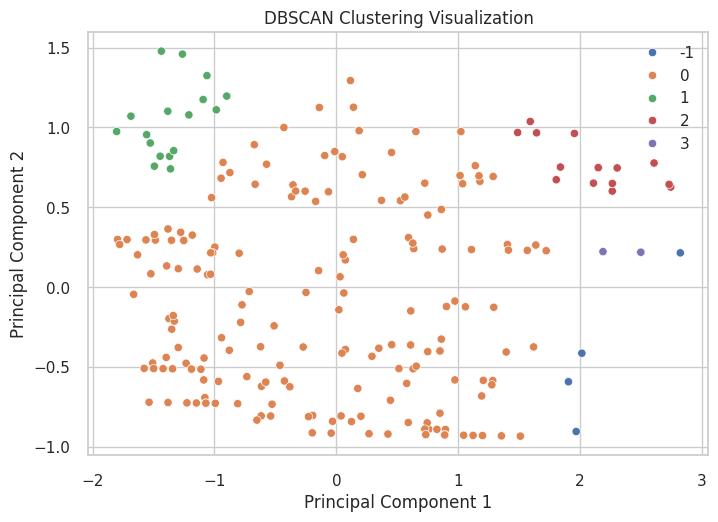

In [ ]:
# Terapkan DBSCAN dengan nilai eps optimal
db = DBSCAN(eps=optimal_eps, min_samples=min_samples).fit(df_dbscan)
labels = db.labels_

# Jumlah cluster dan noise
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)

# Visualisasi Hasil Clustering
sns.scatterplot(
    x=df_dbscan['PC1'],
    y=df_dbscan['PC2'],
    hue=labels,
    palette="deep"
)

plt.title("DBSCAN Clustering Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [ ]:
dbscan_silhouette = silhouette_score(df_dbscan, labels)
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")

DBSCAN Silhouette Score: 0.2642574074353147


In [ ]:
df_dbscan['cluster'] = db.labels_
df_dbscan.head()

,PC1,PC2,cluster
0,1.108821,0.235255,0
1,2.821813,0.214510,-1
2,0.758503,-0.890190,0
3,0.895076,-0.891844,0
4,0.825238,-0.890998,0


## Statistika Deskriptif Cluster

In [ ]:
df_hasil1 = df.copy()

In [ ]:
df_hasil1['cluster'] = db.labels_
df_hasil1['PC1'] = df_dbscan['PC1']
df_hasil1['PC2'] = df_dbscan['PC2']
df_hasil1.head()

,name,price,kecamatan,gender,Akses 24 Jam,kasur,ac,Kamar Mandi Dalam,kloset duduk,Wifi,cluster,PC1,PC2
0,Kost Singgahsini Opung Erwin Tipe A Mojo Surab...,1605000,Kecamatan Gubeng,Campur,1,1,1,1,1,1,0,1.108821,0.235255
1,Kost Singgahsini Graha Ara Dharmahusada Tipe B...,2708750,Kecamatan Gubeng,Campur,1,1,1,1,1,1,-1,2.821813,0.214510
2,Kost Singgahsini Kertajaya Utimami Tipe A Gube...,1521000,Kecamatan Gubeng,Putri,0,1,1,1,1,1,0,0.758503,-0.890190
4,Kost Singgahsini Kertajaya Utimami Tipe C Gube...,1609000,Kecamatan Gubeng,Putri,0,1,1,1,1,1,0,0.825238,-0.890998
5,Kost Singgahsini Kertajaya Utimami Tipe B Gube...,1564000,Kecamatan Gubeng,Putri,0,1,1,1,1,1,0,-0.809107,-0.730240


In [ ]:
statistika_deskriptif = df_hasil1.groupby('cluster').agg(
    jumlah_data=('name', 'count'),
    harga_rata_rata=('price', 'mean'),
    harga_std=('price', 'std'),
    harga_min=('price', 'min'),
    harga_25_percentile=('price', lambda x: x.quantile(0.25)),
    harga_median=('price', 'median'),
    harga_75_percentile=('price', lambda x: x.quantile(0.75)),
    harga_max=('price', 'max'),
    PC1_mean=('PC1','mean'),
    PC2_mean=('PC2','mean'),
    akses_24_jam_1=('Akses 24 Jam', lambda x: (x == 1).sum()),
    akses_24_jam_0=('Akses 24 Jam', lambda x: (x == 0).sum()),
    kasur_1=('kasur', lambda x: (x == 1).sum()),
    kasur_0=('kasur', lambda x: (x == 0).sum()),
    ac_1=('ac', lambda x: (x == 1).sum()),
    ac_0=('ac', lambda x: (x == 0).sum()),
    kamar_mandi_dalam_1=('Kamar Mandi Dalam', lambda x: (x == 1).sum()),
    kamar_mandi_dalam_0=('Kamar Mandi Dalam', lambda x: (x == 0).sum()),
    kloset_duduk_1=('kloset duduk', lambda x: (x == 1).sum()),
    kloset_duduk_0=('kloset duduk', lambda x: (x == 0).sum()),
    wifi_1=('Wifi', lambda x: (x == 1).sum()),
    wifi_0=('Wifi', lambda x: (x == 0).sum())
)

statistika_deskriptif

,jumlah_data,harga_rata_rata,harga_std,harga_min,harga_25_percentile,harga_median,harga_75_percentile,harga_max,PC1_mean,PC2_mean,...,kasur_1,kasur_0,ac_1,ac_0,kamar_mandi_dalam_1,kamar_mandi_dalam_0,kloset_duduk_1,kloset_duduk_0,wifi_1,wifi_0
cluster,,,,,,,,,,,,,,,,,,,,,
-1,4,2.364688e+06,232979.735796,2200000,2237500.0,2275000.0,2402187.5,2708750,1.140514,-0.177548,...,4,0,4,0,4,0,4,0,4,0
0,194,1.149235e+06,424813.764021,400000,776250.0,1100000.0,1500000.0,2000000,-0.081287,-0.007552,...,185,9,105,89,98,96,136,58,153,41
1,17,6.117647e+05,91051.859819,450000,600000.0,600000.0,650000.0,750000,-0.110269,0.096033,...,15,2,0,17,0,17,3,14,6,11
2,15,2.213333e+06,229492.193041,1900000,2000000.0,2200000.0,2300000.0,2600000,0.738385,0.064207,...,15,0,15,0,15,0,12,3,14,1
3,3,2.433333e+06,115470.053838,2300000,2400000.0,2500000.0,2500000.0,2500000,0.827521,-0.383293,...,3,0,3,0,3,0,3,0,3,0


## Visualisasi Pola Cluster

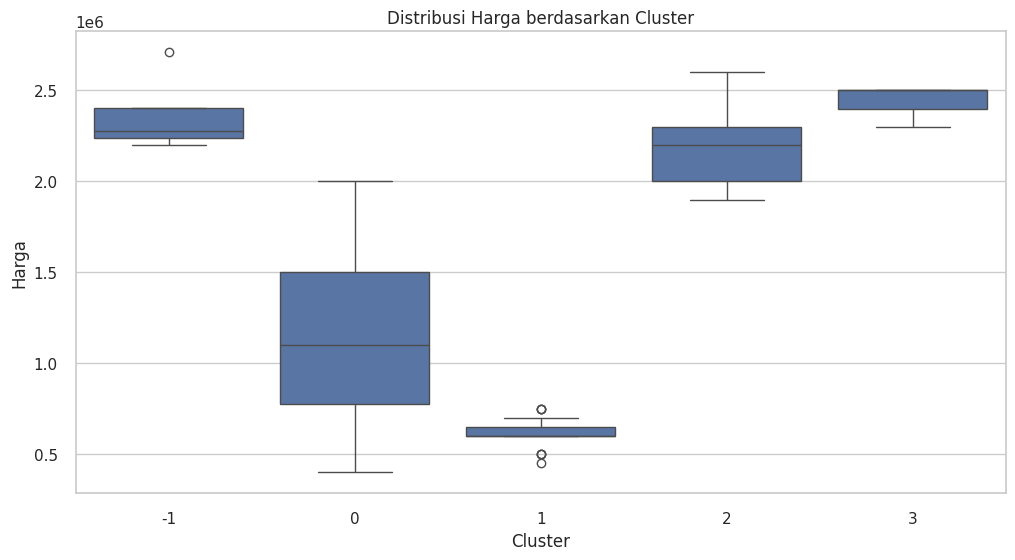

In [ ]:
sns.set(style="whitegrid")

# Plot untuk melihat distribusi harga berdasarkan cluster
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='price', data=df_hasil1)
plt.title('Distribusi Harga berdasarkan Cluster')
plt.xlabel('Cluster')
plt.ylabel('Harga')
plt.show()

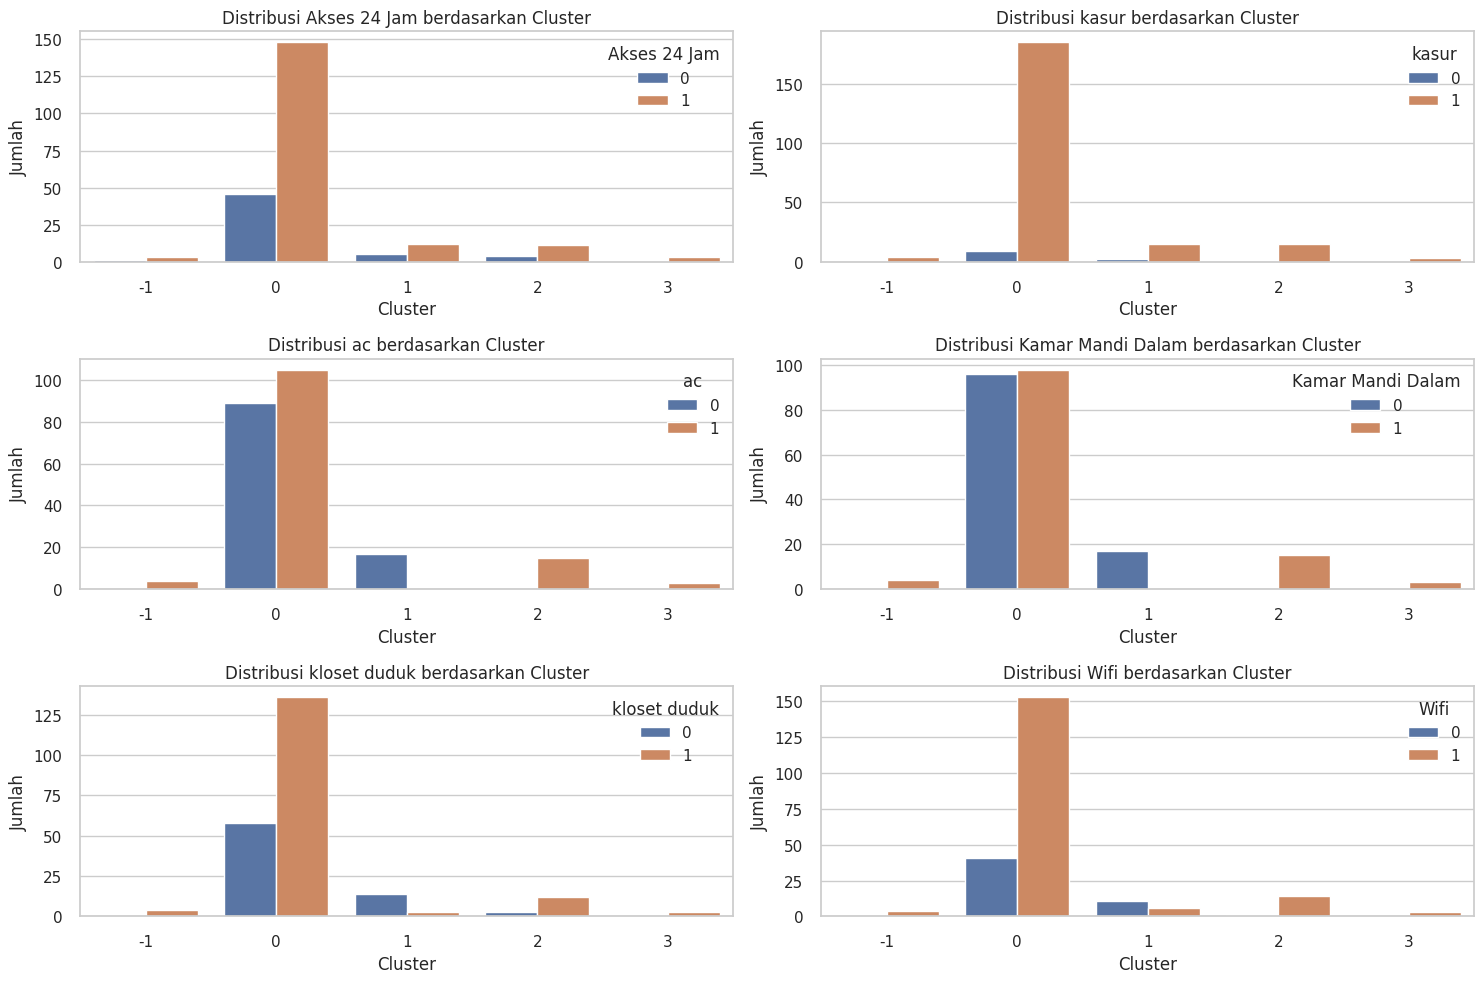

In [ ]:
# Plot untuk melihat distribusi fasilitas berdasarkan cluster
fasilitas = ['Akses 24 Jam', 'kasur', 'ac', 'Kamar Mandi Dalam', 'kloset duduk', 'Wifi']

plt.figure(figsize=(15, 10))
for i, fasilitas in enumerate(fasilitas, 1):
    plt.subplot(3, 2, i)
    sns.countplot(x='cluster', hue=fasilitas, data=df_hasil1)
    plt.title(f'Distribusi {fasilitas} berdasarkan Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Jumlah')
    plt.legend(title=fasilitas)
plt.tight_layout()
plt.show()